In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

In [3]:
import pandas as pd
consensus_genes = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_consensus_males_50-70.csv", index_col=0)

In [4]:
mask = ((ppmi_ad.obs['Age_Group'] == '50-70') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [5]:
ppmi_ad = ppmi_ad[mask]

In [6]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(consensus_genes.index)]

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_9233/3785693463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


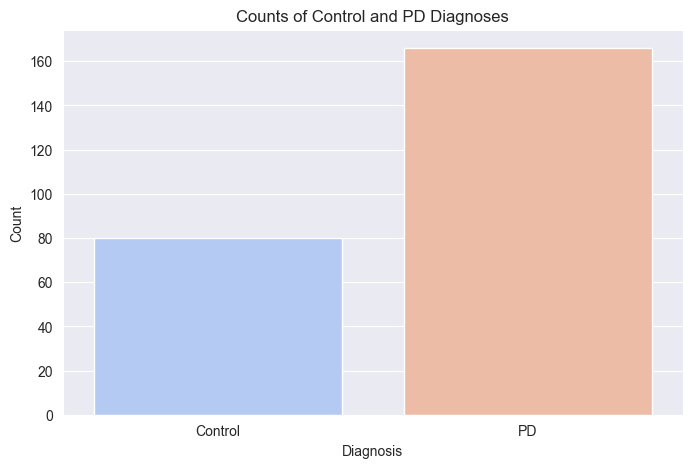

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=ppmi_ad.obs,
    x='Diagnosis',
    palette='coolwarm'
)
plt.title('Counts of Control and PD Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [8]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [39]:
rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=500,
        max_depth=8,
        class_weight='balanced_subsample',
        random_state=42,
        min_samples_leaf=10,
        n_jobs=-1
    ))
])

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [5, 8, None],
    'rf__max_features': ['sqrt', 0.5],
    'smote__k_neighbors': [3, 5]
}

In [41]:
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=StratifiedKFold(10),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [14]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:,1]

In [15]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.31      0.37        16
           1       0.72      0.82      0.77        34

    accuracy                           0.66        50
   macro avg       0.59      0.57      0.57        50
weighted avg       0.63      0.66      0.64        50



In [16]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")


ROC-AUC: 0.608
PR-AUC: 0.771


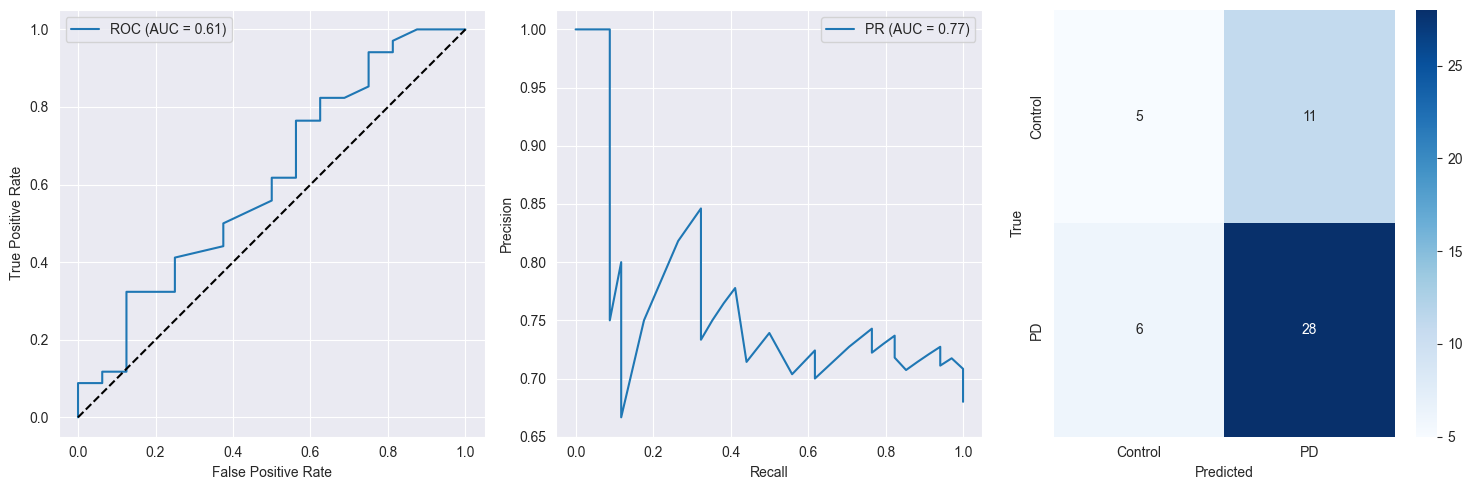

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [18]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = {'roc_auc': [], 'pr_auc': []}

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf_pipeline.fit(X_train, y_train)
    y_proba = rf_pipeline.predict_proba(X_val)[:, 1]

    cv_scores['roc_auc'].append(roc_auc_score(y_val, y_proba))
    cv_scores['pr_auc'].append(average_precision_score(y_val, y_proba))

print("\nCross-validation results:")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.3f} ± {np.std(cv_scores['roc_auc']):.3f}")
print(f"PR-AUC: {np.mean(cv_scores['pr_auc']):.3f} ± {np.std(cv_scores['pr_auc']):.3f}")


Cross-validation results:
ROC-AUC: 0.679 ± 0.117
PR-AUC: 0.827 ± 0.069


In [19]:
rf = rf_pipeline.named_steps['rf']
importances = pd.DataFrame({
    'ensembl_id': consensus_genes.index,
    'gene_symbol': consensus_genes['gene_symbol'],
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 important genes:")
print(importances.head(40)[['gene_symbol', 'importance']])


Top 20 important genes:
                        gene_symbol  importance
ENSG00000238837.3         LINC02031    0.009818
ENSG00000259692.5         LINC01418    0.006882
ENSG00000199289.1         RNU6-502P    0.005892
ENSG00000264734.1   ENSG00000264734    0.005699
ENSG00000228948.2         SLC25A6P5    0.005644
ENSG00000278004.1   ENSG00000278004    0.003889
ENSG00000240244.3          GAPDHP33    0.003806
ENSG00000145979.17           TBC1D7    0.003635
ENSG00000249503.1          HMGN1P16    0.003497
ENSG00000182565.8            OR4C2P    0.003456
ENSG00000279901.1   ENSG00000279901    0.003418
ENSG00000197990.6           ZNF734P    0.003347
ENSG00000109743.10             BST1    0.003345
ENSG00000250303.3         LINC02762    0.003320
ENSG00000138668.18           HNRNPD    0.003273
ENSG00000111859.16            NEDD9    0.003190
ENSG00000276649.1   ENSG00000276649    0.003074
ENSG00000259106.1   ENSG00000259106    0.003072
ENSG00000267120.3   ENSG00000267120    0.003071
ENSG00000274584

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_9233/4141259349.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


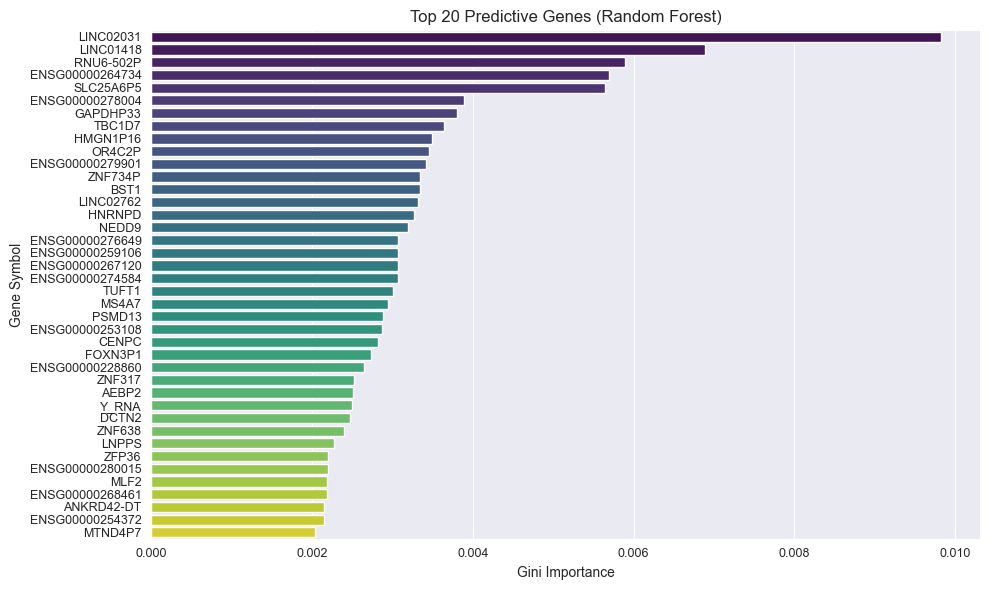

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importances.head(40),
    x='importance',
    y='gene_symbol',
    palette='viridis'
)
plt.title('Top 20 Predictive Genes (Random Forest)')
plt.xlabel('Gini Importance')
plt.ylabel('Gene Symbol')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

Class distribution informs us about the counts for each class in the model. That is, the number of control and the number of case samples. As such, the prediction on X_test bincount will yield the class distribution as per the prediction capabilities of the model deliver. On the other hand, the bincount on y_test will yield the true distribution, just like its present in the test output vector for the model.

In [23]:
print("Class distribution in predictions: ", np.bincount(best_rf.predict(X_test)))

Class distribution in predictions:  [11 39]


In [30]:
print("True class distribution: ", np.bincount(y_test))

True class distribution:  [16 34]


In [37]:
print("Top gene:", consensus_genes.iloc[np.argmax(best_rf.named_steps['rf'].feature_importances_)]['gene_symbol'])
print("Importance ratio (top/bottom):",
      best_rf.named_steps['rf'].feature_importances_.max() / best_rf.named_steps['rf'].feature_importances_.min())

Top gene: ENSG00000278004
Importance ratio (top/bottom): inf


/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_9233/3630269466.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  best_rf.named_steps['rf'].feature_importances_.max() / best_rf.named_steps['rf'].feature_importances_.min())


In [29]:
print("Unique predicted probabilities: ", np.unique(best_rf.predict_proba(X_test)[:,1]))

Unique predicted probabilities:  [0.36 0.37 0.39 0.4  0.42 0.43 0.44 0.46 0.5  0.51 0.53 0.54 0.56 0.57
 0.58 0.59 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.74 0.77
 0.8  0.82 0.83 0.87]
